<div style="text-align: right"> &uarr;   Ensure Kernel is set to  &uarr;  </div><br><div style="text-align: right"> conda_amazonei_tensorflow2_p36  </div>

# Tensorflow Estimator Bring your own Script

In this notebook we will go through and run a tensorflow model to classify the junctions as priority, signal and roundabout as seen in data prep.

The outline of this notebook is 

1. To prepare a training script (provided).

2. Use the AWS provided Tensorflow container and provide our script to it.

3. Run training.

4. Deploy model to end point.

5. Test using an image in couple of possible ways 

Upgrade Sagemaker so we can access the latest containers

In [1]:
!pip install -U 'sagemaker>=2.48'

     |████████████████████████████████| 534 kB 28.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.91.1-py2.py3-none-any.whl size=737673 sha256=170f22f9c8f40c1bd49424b53aa2a5e3041edb581c121141ba309a38f77802b0
  Stored in directory: /home/ec2-user/.cache/pip/wheels/49/c1/2e/5d7bcd98cc65e1db77f617e66ec2577082381ba5570282474f
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.86.2
    Uninstalling sagemaker-2.86.2:
      Successfully uninstalled sagemaker-2.86.2


Let us also upgrade out version of Tensorflow to v2.4.1

In [2]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 15 kB/s               1.6 MB/s eta 0:00:01�█▋| 389.9 MB 111.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 58.6 MB/s            
     |████████████████████████████████| 462 kB 48.7 MB/s            
     |████████████████████████████████| 132 kB 99.7 MB/s            
     |████████████████████████████████| 3.8 MB 55.7 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.0.0
    Uninstalli

Lets make sure that our environment is using Tensorflow 2.4.1 otherwise we will need to restart the notebook kernel

In [3]:
import tensorflow as tf

print(f"Tensorflow version {tf.__version__}")

if tf.__version__ != "2.4.1":
    print("This notebook kernel needs to be restarted!!!!")
    exit()

Tensorflow version 2.4.1


Lets start by importing some libraries that we will be using later

In [4]:
import os
import sagemaker
import numpy as np
from sagemaker.tensorflow import TensorFlow
# if you are using pytorch
# from sagemaker.pytorch import PyTorch


ON_SAGEMAKER_NOTEBOOK = True

sagemaker_session = sagemaker.Session()
if ON_SAGEMAKER_NOTEBOOK:
    role = sagemaker.get_execution_role()
else:
    role = "[YOUR ROLE]"


A quick sanity check to make sure we are using the latest version of SageMaker

In [5]:
sagemaker.__version__

'2.91.1'

#### Input params for model training 

In the cell below, replace **"your-unique-bucket-name"** with the name of bucket you created in the data-prep notebook

In [8]:
bucket = "mherrfurth-bucket"

train_instance_type='ml.m5.12xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m5.4xlarge'     # The type of EC2 instance which will be used for deployment

'''
we can use the train and validation path as stated above 
or you can 
just rearrange data and use a single path like below
'''
training_data_uri="s3://{}".format(bucket)

### Tensorflow Estimator

Use AWS provided open source containers, these containers can be extended by starting with the image provided by AWS and the add additional installs in dockerfile

or you can use requirements.txt in source_dir to install additional libraries.

We setup the Tensorflow estimator job a job name, an entry point (which is our script **tfModelCode.py**), role, Tensorflow framework version, python version, instance count and type. <br>
Then we call the estimators fit method with the URI of the training dataset to kick off the training job.<br>
**Note: This cell will take approx 30 mins to complete**


In [9]:
%%time
estimator_tf = TensorFlow(
  base_job_name='tensorflow-pssummit-traffic-class',
  entry_point="tfModelCode.py",             # Your entry script
  role=role,
  framework_version="2.4.1",               # TensorFlow's version
  py_version="py37",
  instance_count=1,  # "The number of GPUs instances to use"
  instance_type=train_instance_type,
)

print("Training ...")
estimator_tf.fit(training_data_uri)

Training ...
2022-05-23 15:21:33 Starting - Starting the training job...
2022-05-23 15:22:01 Starting - Preparing the instances for trainingProfilerReport-1653319293: InProgress
.........
2022-05-23 15:23:24 Downloading - Downloading input data......
2022-05-23 15:24:21 Training - Training image download completed. Training in progress.2022-05-23 15:24:17.373183: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-23 15:24:17.376223: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-05-23 15:24:17.455065: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-23 15:24:20,364 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-05-23 15:24:20,371 sagemaker-training-toolkit INFO     No GPUs de

In [29]:
estimator_tf.__class__

sagemaker.tensorflow.estimator.TensorFlow

In [30]:
help(estimator_tf.deploy)

Help on method deploy in module sagemaker.estimator:

deploy(initial_instance_count=None, instance_type=None, serializer=None, deserializer=None, accelerator_type=None, endpoint_name=None, use_compiled_model=False, wait=True, model_name=None, kms_key=None, data_capture_config=None, tags=None, serverless_inference_config=None, async_inference_config=None, **kwargs) method of sagemaker.tensorflow.estimator.TensorFlow instance
    Deploy the trained model to an Amazon SageMaker endpoint.
    
     And then return ``sagemaker.Predictor`` object.
    
    More information:
    http://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html
    
    Args:
        initial_instance_count (int): The initial number of instances to run
            in the ``Endpoint`` created from this ``Model``. If not using
            serverless inference, then it need to be a number larger or equals
            to 1 (default: None)
        instance_type (str): The EC2 instance type to deploy this Mod

## **NOTE:** <br>
If at this point your kernel disconnects from the server (you can tell because the kernel in the top right hand corner will say **No Kernel**, you can reattach to the training job (so you dont to start the training job again.<br>Follow the steps below
1. Scoll your notebook to the top and set the kernel to the recommended kernel specified in the top right hand corner of the notebook
2. Go to your SageMaker console, Go to Training Jobs and copy the name of the training job you were disconnected from
3. Scoll to the bottom of this notebook, paste your training job name to replace the **your-training-job-name** in the cell
4. Run the edited cell
5. Return to this cell and continue executing the rest of this notebook

#### Deploying a model
Once trained, deploying a model is a simple call. <br>
We specify two prarameters<br>
    **instance_type** - the type of the instance will be used to do inference<br>
    **initial_instance_count** - the initial number of instances that will be provisioned to do inference

In [10]:
estimator_deployed=estimator_tf.deploy(instance_type='ml.m5.2xlarge', initial_instance_count=1)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

Now that the estimator has been deployed to an endpoint, lets find out the endpoint name

In [11]:
print(estimator_deployed.endpoint_name)

tensorflow-pssummit-traffic-class-2022-05-23-15-57-01-410


So to do predictions againast this endpoint, we are going to use Predictor. We provide it the endpoint name, the SageMaker session and the serializer (in our case a JSONSerializer)
Serializers implement methods for serializing data for an inference endpoint<br>
**NOTE** Replace **'your-endpoint-name'** with your endpoint name

In [22]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
estimator_tf
endpoint_name = 'tensorflow-pssummit-traffic-class-2022-05-23-15-57-01-410'

predictor=Predictor(endpoint_name=endpoint_name,
                    sagemaker_session=sagemaker_session, 
                    serializer=JSONSerializer())

Here we install some convenience libraries

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import json

Now we will take one of our test images and apply some preprocessing to it

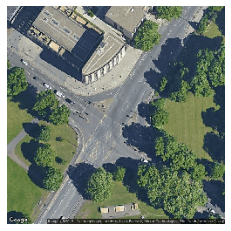

In [36]:
file='../data/test/Signal/S1.png'
img = tf.keras.preprocessing.image.load_img(file, target_size=[250, 250])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.efficientnet.preprocess_input(
    x[tf.newaxis,...])


Now we send that processed data to our endpoint.

In [37]:
img.__class__

PIL.Image.Image

In [38]:
predictor.predict(x)

b'{\n    "predictions": [[0.431799144, 0.172305837, 0.395895034]\n    ]\n}'

### As you can see the prediction has sent back a confidence score for each class. The second value in the list corresponds to the class label "Roundabout" which has the highest confidence score

### Using boto3 sagemaker_runtime client

So what if we want to make predictions against this endpoint outside of this notebook?<br>
We then leverage the boto3 library. <br>
**NOTE** Replace **'your-endpoint-name'** with your endpoint name

In [27]:
import boto3
client=boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
            EndpointName='tensorflow-pssummit-traffic-class-2022-05-23-15-57-01-410',
            ContentType='application/json',
            Body=json.dumps({'instances':x.tolist()}))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


We can now view the JSON response. Again the second value in the list corresponds to the class label "Roundabout" which has the highest confidence score

In [28]:
json.loads(response['Body'].read().decode("utf-8"))

{'predictions': [[0.15773654, 0.833805, 0.00845843926]]}

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [39]:
predictor.delete_endpoint()

## Batch Inference

We will start by creating a S3 URI to the model artifacts package generated from the training step

In [40]:
model_data = f"{estimator_tf.output_path}{estimator_tf._current_job_name}/output/model.tar.gz"

First let us make sure we are in the correct starting folder

In [41]:
%cd ~/SageMaker/pssummitwkshp/tensorflow/

/home/ec2-user/SageMaker/pssummitwkshp/tensorflow


Now we will create a local export folder so we can store our inference code in a code folder. We can also specify a requirements.txt for any package dependencies  

In [42]:
! mkdir ./export

mkdir: cannot create directory ‘./export’: File exists


Now we copy and unpack the model artifacts file

In [43]:
!aws s3 cp {model_data} ./export/

download: s3://sagemaker-us-east-1-779416346969/tensorflow-pssummit-traffic-class-2022-05-23-15-21-33-155/output/model.tar.gz to export/model.tar.gz


In [44]:
!tar -xvzf ./export/model.tar.gz -C ./export/

tf000000001/
tf000000001/1/
tf000000001/1/variables/
tf000000001/1/variables/variables.data-00000-of-00001
tf000000001/1/variables/variables.index
tf000000001/1/saved_model.pb
tf000000001/1/assets/


In [45]:
%cd export

/home/ec2-user/SageMaker/pssummitwkshp/tensorflow/export


We now delete any old model artifacts folders and move the unpacked model artifacts folder to the 1 folder

In [46]:
! rm -r 1

rm: cannot remove ‘1’: No such file or directory


In [47]:
! mv tf000000001/1 .

In [48]:
! rm -r code/.ipynb_checkpoints/

rm: cannot remove ‘code/.ipynb_checkpoints/’: No such file or directory


We now package up the code and 1 folder to create a new model.tar.gz file

In [49]:
! tar -czvf model.tar.gz code 1

code/
code/inference.py
code/requirements.txt
1/
1/variables/
1/variables/variables.data-00000-of-00001
1/variables/variables.index
1/saved_model.pb
1/assets/


We copy the new model.tar.gz to your S3 bucket and setup our Tensorflow Serving Container https://github.com/aws/sagemaker-tensorflow-serving-container

In [50]:
import os
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
sm_role=sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
# See the following document for more on SageMaker Roles:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html
role = sm_role

# Will be using the bucket variable defined at beginning of this notebook

prefix = 'tf_model'
s3_path = 's3://{}/{}'.format(bucket, prefix)

model_data = sagemaker_session.upload_data('model.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))
                                           
tensorflow_serving_model = TensorFlowModel(model_data=model_data,
                                 role=role,
                                 framework_version='2.4.1',
                                 sagemaker_session=sagemaker_session)

We then specify the output folder and run the transformer method to start the batch processing

In [51]:
output_path = f's3://{bucket}/{prefix}/output'
tensorflow_serving_transformer = tensorflow_serving_model.transformer(
                                     instance_count=2,
                                     instance_type='ml.m5.4xlarge',
                                     max_concurrent_transforms=64,
                                     max_payload=1,
                                     output_path=output_path)

input_path = f's3://{bucket}/test'
tensorflow_serving_transformer.transform(input_path, content_type='application/x-image')

.........................INFO:__main__:PYTHON SERVICE: True
INFO:__main__:starting services
INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: 'model'
    base_path: '/opt/ml/model'
    model_platform: 'tensorflow'
    model_version_policy: {
      specific: {
        versions: 1
      }
    }
  }
}
INFO:__main__:tensorflow version info:
2022-05-23 16:28:37.164838: W external/org_tensorflow/tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-05-23 16:28:37.164949: W external/org_tensorflow/tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
TensorFlow ModelServer: 2.4.0-rc4+dev.sha.no_git
TensorFlow Library: 2.4.1
INFO:__main__:tensorflow serving command: tensorflow_model_server --port=10000 --rest_api_port=10001 --mode

The output of this batch job will be in the following S3 URI

In [52]:
output_path

's3://mherrfurth-bucket/tf_model/output'

We can look at the output file from the batch job. Each file is a prediction that corresponds to the input image file name 

In [ ]:
! aws s3 ls {output_path} --recursive | grep -v ".ipy"

### Attach to a training job that has been left to run 

If your kernel becomes disconnected and your training has already started, you can reattach to the training job.<br>
In the cell below, replace **your-unique-bucket-name** with the name of bucket you created in the data-prep notebook<br>
Then look up the training job name and replace the **your-training-job-name** and then run the cell below. <br>
Once the training job is finished, you can continue the cells after the training cell

In [ ]:
import tensorflow as tf
from sagemaker.tensorflow import TensorFlow
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "your-unique-bucket-name"

training_job_name = 'your-training-job-name'

if 'your-training' not in training_job_name:
    estimator_tf = TensorFlow.attach(training_job_name=training_job_name)